# HSI image StO2 estimation on INN model

## Preparation

In [1]:
# %matplotlib notebook
name_model = "model_generic_0613"
c = None
exec('import models.' + name_model + "_config as c")

from src.inn_model import *
from src.dataset import *
from src.visualisation import *
from tqdm import tqdm

import copy
import torch
import pandas as pd
import numpy as np

from hvs_hsi_pytorch.utils import hsi_utils, utils
from hvs_hsi_pytorch.definitions import DIR_DATA

In [2]:
# Read reformatted dataset
data_colon = pd.read_csv("data/mc/generic_train_15.7.15.4_power_led_300_norm_l1.csv")

N = len(data_colon)
n_train = int(N * 0.9)
train_df = data_colon[:n_train]

c.parameters = ['sao2', 'vhb']
c.n_spectrum_start = 24
c.target = 1

# Data loader
train_dataset = McDataset(train_df, c)
train_loader = data_utils.DataLoader(train_dataset, batch_size=c.batch_size, shuffle=True, drop_last=True)

# Set up dimensionality
c.ndim_y = train_dataset.get_y_dim()
c.ndim_x = 10
c.ndim_tot = max(c.ndim_y, c.ndim_x) + c.ndim_z

# Model
model = inn_model_1(c)
model.load_state_dict(torch.load('models/' + name_model, map_location=torch.device(c.device)))
_ = model.eval()

In [3]:
image_path = os.path.join(DIR_DATA, 'helicoid/028-05')
hsi_data = hsi_utils.load_helicoid(image_path)
hsi_data.array = hsi_data.array[:,:480, :384]
hsi_origin = copy.deepcopy(hsi_data)
hsi_data.array = utils.normalise_L1(hsi_data.array)

In [4]:
%%time

# Data reformat
data = hsi_data.array
shape = data.shape
data = data.reshape(shape[0], shape[1] * shape[2]).swapaxes(0, 1)

step = 2 ** 11
batch = list(np.arange(data.shape[0], step=step))
batch.append(data.shape[0])

output = torch.tensor([])
for i in tqdm(range(len(batch) - 1), ascii=True, ncols=100):
    y = data[batch[i]:batch[i + 1]].to(c.device)
    z = torch.randn(y.shape[0], c.ndim_z).to(c.device)
    y = torch.cat((torch.zeros(y.shape[0], c.ndim_tot - c.ndim_y - c.ndim_z).to(c.device), y), dim=1)
    y = torch.cat((z, y), dim=1).to(c.device)
    pred_x = model(y, rev=True)[0][:, c.target].detach().cpu().clone()
    output = torch.cat((output, pred_x))

output = output.reshape(shape[1], shape[2])[:, :, None]

  3%|##1                                                             | 3/90 [00:02<01:25,  1.02it/s]


KeyboardInterrupt: 

## HVS Sto2 estimation

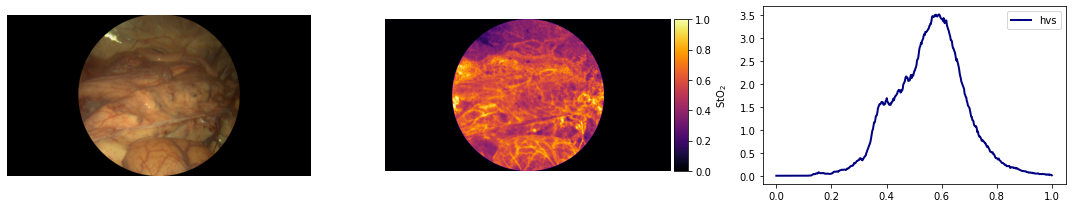

In [8]:
show_hvs_combo(hsi_origin, mask=False)

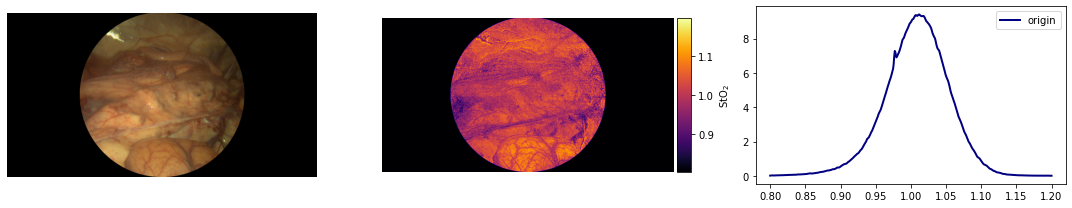

In [9]:
show_inn_combo_origin(hsi_origin, output, mask=False, aim_range=(0.8, 1.2))

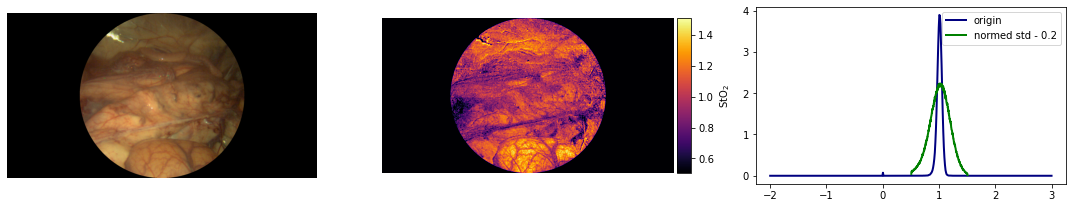

In [10]:
show_inn_combo_norm(hsi_origin, output, mask=False)

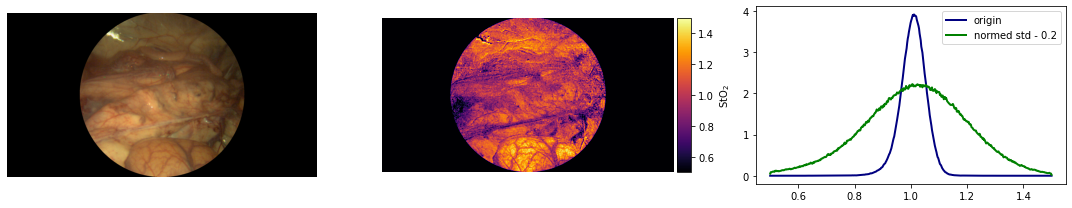

In [11]:
show_inn_combo_range(hsi_origin, output, mask=False, aim_range=(0.5, 1.5))